# Disciplina Tópicos Especiais II (C318)

### Curso: Fundamentos de Machine Learning
### Professor: Ricardo Augusto

-------------------------------------------------------------------------------------------------------------------------------

Definir o Problema: Recomendação de filmes na Netflix.
Objetivo: Criar um sistema que recomende filmes aos usuários com base em suas preferências e histórico de visualização.

Perguntas de Negócio:
Como podemos melhorar a experiência do usuário através de recomendações personalizadas?
Quais fatores influenciam as recomendações de filmes?


Pesquisa Inicial: Investigar os métodos de recomendação existentes (Filtragem Colaborativa, Baseada em Conteúdo, Híbrida).


# 1. Importação de Bibliotecas


In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: C:\Users\thiag\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
import random
import matplotlib.pyplot as plt

# Configurações de visualização
sns.set(style='whitegrid')
plt.style.use('ggplot')

# 2. Carregamento dos Dados


In [4]:
df_netflix = pd.read_csv('C:\\C318\\Projeto_C318\\Datasets\\NetFlix.csv')
df_titles = pd.read_csv('C:\\C318\\Projeto_C318\\Datasets\\netflix_titles.csv')

print("----------------------------------------Dataframe 1----------------------------------------")
print(df_netflix.head())
print("----------------------------------------Dataframe 2----------------------------------------")
print(df_titles.head())

----------------------------------------Dataframe 1----------------------------------------
  show_id     type                                      title        director  \
0      s1  TV Show                                         3%             NaN   
1     s10    Movie                                       1920    Vikram Bhatt   
2    s100    Movie                                 3 Heroines  Iman Brotoseno   
3   s1000    Movie  Blue Mountain State: The Rise of Thadland    Lev L. Spiro   
4   s1001  TV Show                             Blue Planet II             NaN   

                                                cast         country  \
0  João Miguel, Bianca Comparato, Michel Gomes, R...          Brazil   
1  Rajneesh Duggal, Adah Sharma, Indraneil Sengup...           India   
2  Reza Rahadian, Bunga Citra Lestari, Tara Basro...       Indonesia   
3  Alan Ritchson, Darin Brooks, James Cade, Rob R...   United States   
4                                 David Attenborough  United 

# 3. Pré-processamento dos Dados

In [5]:
# Visualizando informações gerais dos datasets
print("Informações gerais do df_netflix:")
print(df_netflix.info())
print("\nInformações gerais do df_titles:")
print(df_titles.info())

# Verificando valores ausentes
print("\nValores ausentes no df_netflix:")
print(df_netflix.isnull().sum())
print("\nValores ausentes no df_titles:")
print(df_titles.isnull().sum())

# Lidando com valores ausentes (remoção ou imputação)
df_netflix = df_netflix.dropna(subset=['title', 'genres', 'rating'])
df_titles = df_titles.dropna(subset=['title', 'listed_in', 'rating'])

# Verificando os tipos de dados das colunas
print("\nTipos de dados das colunas do df_netflix:")
print(df_netflix.dtypes)
print("\nTipos de dados das colunas do df_titles:")
print(df_titles.dtypes)

# Convertendo durações de strings para números (apenas se a coluna for do tipo object)
if df_netflix['duration'].dtype == 'object':
    df_netflix['duration'] = df_netflix['duration'].str.replace(' min', '').astype(int)
if df_titles['duration'].dtype == 'object':
    df_titles['duration'] = df_titles['duration'].str.extract('(\d+)').astype(float)

# Normalizando colunas numéricas, se necessário
from sklearn.preprocessing import StandardScaler

# Supondo que df_netflix tenha colunas numéricas que precisam ser normalizadas
scaler = StandardScaler()
df_netflix_scaled = scaler.fit_transform(df_netflix.select_dtypes(include=[np.number]))

# Convertendo de volta para DataFrame para facilitar a manipulação
df_netflix_scaled = pd.DataFrame(df_netflix_scaled, columns=df_netflix.select_dtypes(include=[np.number]).columns)

# Adicionando colunas categóricas de volta ao DataFrame normalizado
df_netflix_scaled['title'] = df_netflix['title'].values
df_netflix_scaled['genres'] = df_netflix['genres'].values
df_netflix_scaled['rating'] = df_netflix['rating'].values

# Exibindo as primeiras linhas do DataFrame normalizado
print("\nPrimeiras linhas do df_netflix_scaled:")
print(df_netflix_scaled.head())



Informações gerais do df_netflix:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   int64 
 10  genres        7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(2), object(10)
memory usage: 730.2+ KB
None

Informações gerais do df_titles:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        -----------

# 4. Análise Exploratória de Dados (EDA)


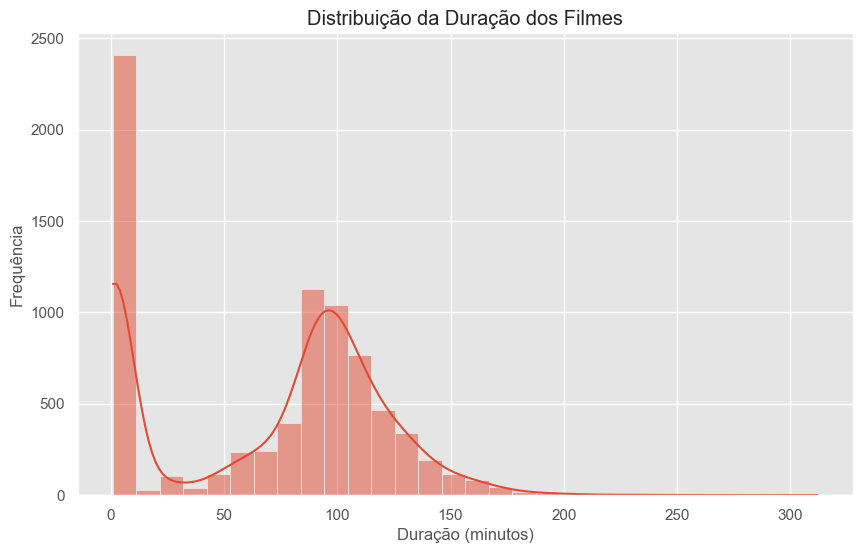

In [6]:
# Plotar a distribuição da duração dos filmes
plt.figure(figsize=(10, 6))
sns.histplot(df_netflix['duration'], kde=True)
plt.title('Distribuição da Duração dos Filmes')
plt.xlabel('Duração (minutos)')
plt.ylabel('Frequência')
plt.show()

C:\Users\thiag\AppData\Local\Temp\ipykernel_24384\1819586178.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')


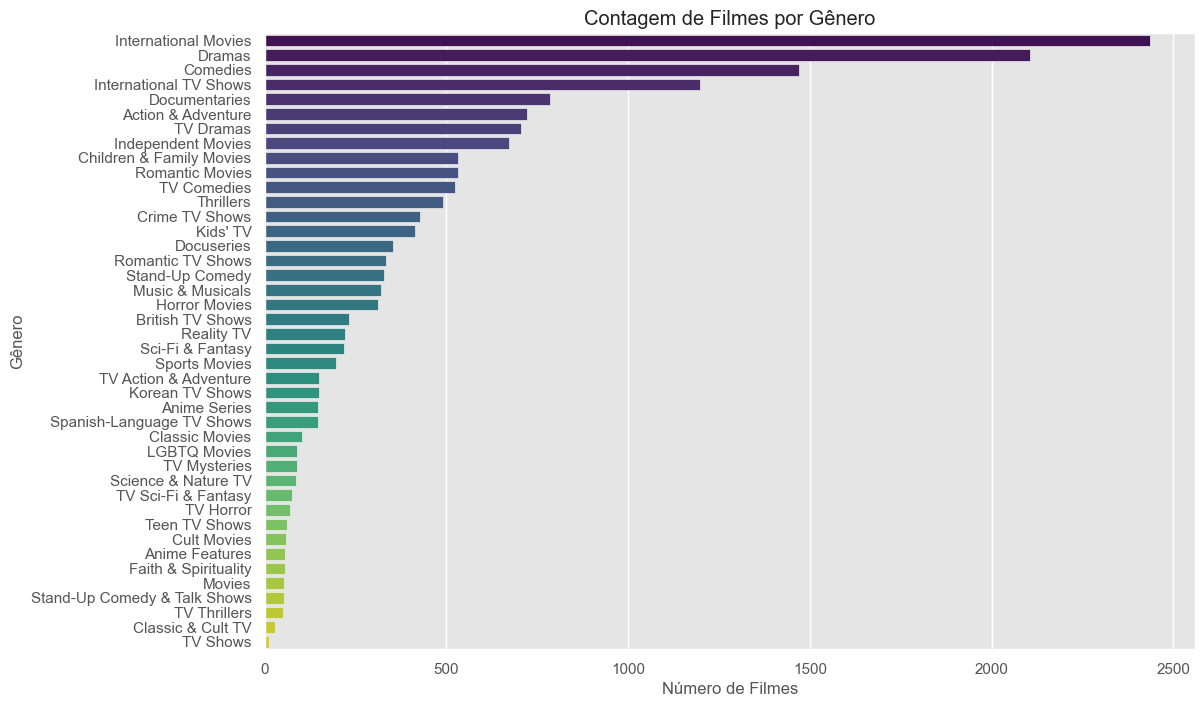

In [7]:
# Separar os gêneros em múltiplas linhas
df_netflix_genres = df_netflix['genres'].str.get_dummies(sep=', ')

# Contagem de filmes por gênero
genre_counts = df_netflix_genres.sum().sort_values(ascending=False)

# Plotar a contagem de filmes por gênero
plt.figure(figsize=(12, 8))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Contagem de Filmes por Gênero')
plt.xlabel('Número de Filmes')
plt.ylabel('Gênero')
plt.show()


C:\Users\thiag\AppData\Local\Temp\ipykernel_24384\2717800527.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_netflix, x='rating', order=df_netflix['rating'].value_counts().index, palette='muted')


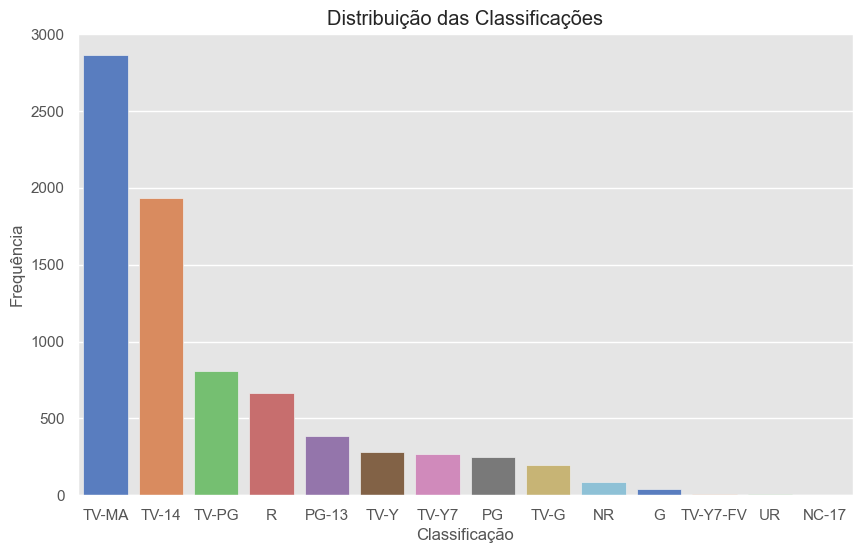

In [8]:
# Plotar a distribuição das classificações
plt.figure(figsize=(10, 6))
sns.countplot(data=df_netflix, x='rating', order=df_netflix['rating'].value_counts().index, palette='muted')
plt.title('Distribuição das Classificações')
plt.xlabel('Classificação')
plt.ylabel('Frequência')
plt.show()


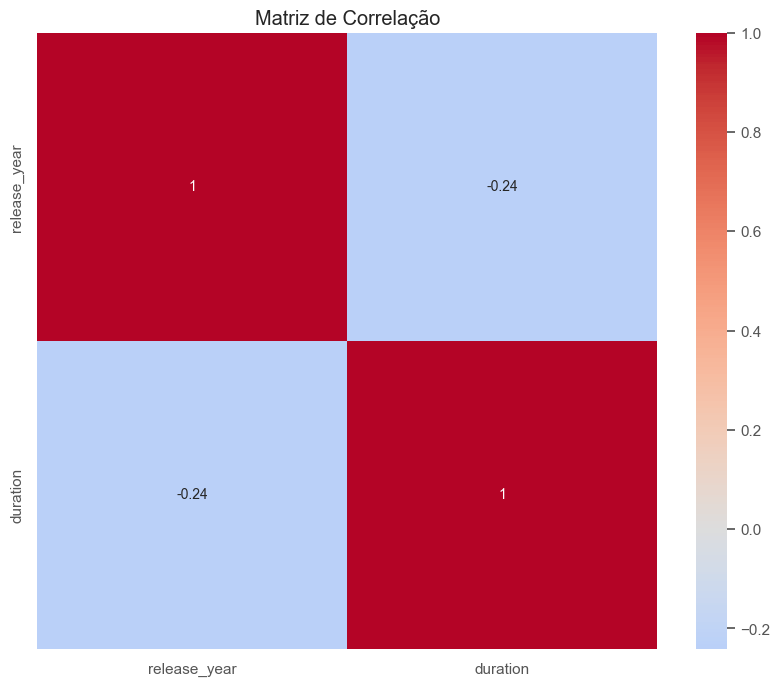

In [9]:
# Selecionar apenas colunas numéricas para cálculo da matriz de correlação
numeric_df_netflix = df_netflix.select_dtypes(include=[np.number])

# Calcular a matriz de correlação
correlation_matrix = numeric_df_netflix.corr()

# Plotar a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação')
plt.show()


In [10]:
print(numeric_df_netflix.head())
print(numeric_df_netflix.info())

   release_year  duration
0          2020         4
1          2008       143
2          2016       124
3          2016        90
4          2017         1
<class 'pandas.core.frame.DataFrame'>
Index: 7780 entries, 0 to 7786
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   release_year  7780 non-null   int64
 1   duration      7780 non-null   int64
dtypes: int64(2)
memory usage: 182.3 KB
None


# 5. Clusterização (PCA e K-Means)


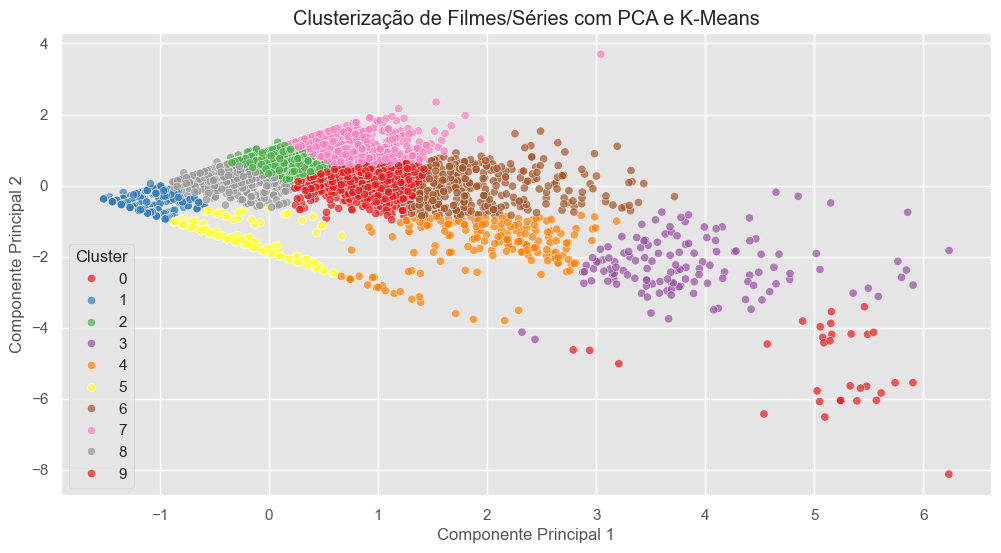

In [11]:
scaler = StandardScaler()
df_netflix_scaled = scaler.fit_transform(numeric_df_netflix)

# Aplicar PCA para reduzir a dimensionalidade para 2 componentes principais
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_netflix_scaled)

# Convertendo o resultado de PCA de volta para DataFrame
df_pca = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2'])

# Adicionando colunas categóricas de volta ao DataFrame PCA
df_pca['title'] = df_netflix['title'].values
df_pca['genres'] = df_netflix['genres'].values
df_pca['rating'] = df_netflix['rating'].values

# 3. Aplicação de K-Means
# Definindo o número de clusters
num_clusters = 10  # Ajuste o número de clusters conforme necessário

# Aplicar K-Means nos dados reduzidos pelo PCA
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(df_pca[['PCA1', 'PCA2']])

# Adicionando os clusters ao DataFrame PCA
df_pca['Cluster'] = clusters

# 4. Visualização dos clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_pca, palette='Set1', alpha=0.7)
plt.title('Clusterização de Filmes/Séries com PCA e K-Means')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

# 6. Implementação da Função de Recomendação

### Recomendação
Quando fornecemos um título, o recomendador:

Identifica o cluster ao qual o título pertence.

Calcula a distância euclidiana entre o título fornecido e os outros títulos do mesmo cluster.

Ordena os títulos pela distância e recomenda os mais próximos.

In [12]:
def recomendador(titulo_filme):
    # Obtendo o índice do filme no DataFrame original
    index_filme = df_netflix[df_netflix['title'] == titulo_filme].index[0]

    # Obtendo o cluster do filme
    cluster = df_pca.loc[index_filme, 'Cluster']

    # Selecionando as recomendações do mesmo cluster
    recomendacoes = df_pca[df_pca['Cluster'] == cluster]

    # Calculando as distâncias euclidianas
    distancias = euclidean_distances(recomendacoes[['PCA1', 'PCA2']], df_pca.loc[index_filme, ['PCA1', 'PCA2']].values.reshape(1, -1))
    recomendacoes['Distancia'] = distancias

    # Ordenando as recomendações pelas distâncias
    recomendacoes = recomendacoes.sort_values('Distancia').head(10)
    recomendacoes_titles = df_netflix.loc[recomendacoes.index, 'title']

    return recomendacoes_titles

# Testando a função de recomendação
print(recomendador('Stranger Things'))

1159                                      Evelyn
6518                                    The Show
279                                        5Gang
3511    Mobile Suit Gundam: Iron-Blooded Orphans
6917                                    Trimurti
3058                          Love Cheque Charge
1686                                 Grand Masti
6190                             The Last Shaman
62                                Born Beautiful
7263                                 West Beirut
Name: title, dtype: object


C:\Users\thiag\AppData\Local\Temp\ipykernel_24384\2699342782.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recomendacoes['Distancia'] = distancias


In [13]:
# Verificar as colunas do DataFrame PCA
print(df_pca.columns)

# Definindo a função de recomendação
def recomendador(titulo_filme):
    # Obtendo o índice do filme no DataFrame original
    try:
        index_filme = df_netflix[df_netflix['title'] == titulo_filme].index[0]
    except IndexError:
        return f"Filme '{titulo_filme}' não encontrado na base de dados."

    # Obtendo o cluster do filme
    cluster = df_pca.loc[index_filme, 'Cluster']

    # Selecionando as recomendações do mesmo cluster
    recomendacoes = df_pca[df_pca['Cluster'] == cluster].copy()

    # Verificar se as colunas PCA1 e PCA2 existem
    if 'PCA1' in recomendacoes.columns and 'PCA2' in recomendacoes.columns:
        pca_columns = ['PCA1', 'PCA2']
    elif 'Componente Principal 1' in recomendacoes.columns and 'Componente Principal 2' in recomendacoes.columns:
        pca_columns = ['Componente Principal 1', 'Componente Principal 2']
    else:
        return "Colunas PCA não encontradas no DataFrame."

    # Calculando as distâncias euclidianas
    distancias = euclidean_distances(
        recomendacoes[pca_columns].values,
        df_pca.loc[index_filme, pca_columns].values.reshape(1, -1)
    )
    recomendacoes['Distancia'] = distancias

    # Ordenando as recomendações pelas distâncias
    recomendacoes = recomendacoes.sort_values('Distancia').head(10)
    recomendacoes_titles = df_netflix.loc[recomendacoes.index, 'title']

    return recomendacoes_titles.tolist()


Index(['PCA1', 'PCA2', 'title', 'genres', 'rating', 'Cluster'], dtype='object')


# 7. Visualização das Recomendações


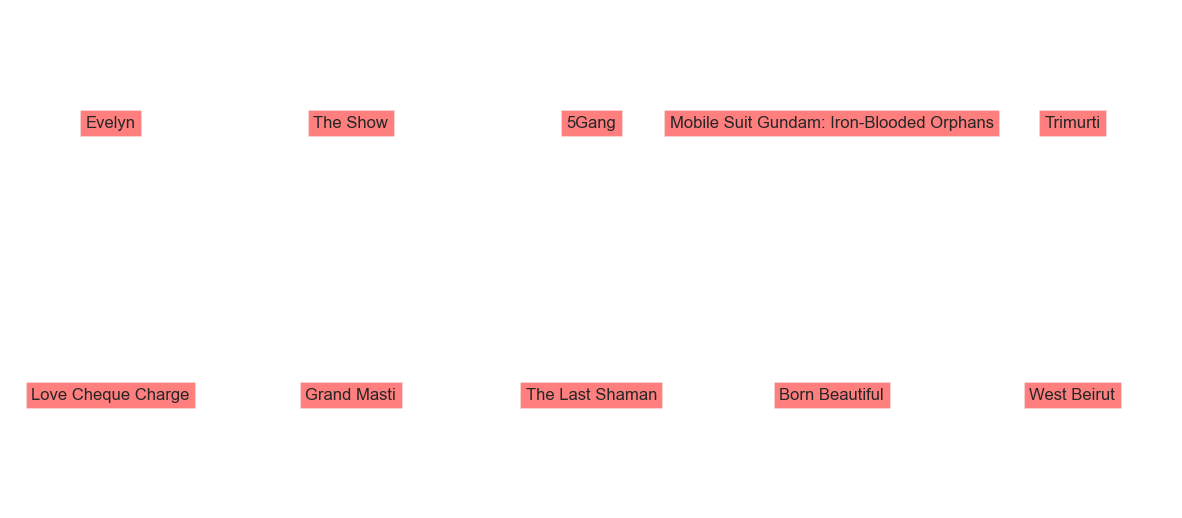

In [14]:
def visualizar_recomendacoes(titulos):
    plt.figure(figsize=(15, 10))
    columns = 5
    for i, titulo in enumerate(titulos):
        ax = plt.subplot(len(titulos) // columns + 1, columns, i + 1)
        plt.text(0.5, 0.5, titulo, horizontalalignment='center', verticalalignment='center', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
        plt.axis('off')
    plt.show()

# Visualizando as recomendações
visualizar_recomendacoes(recomendador('Stranger Things'))

Menu de Recomendações
1. Inserir título do filme/série
2. Obter recomendação aleatória
3. Sair
Recomendações para: Trotro


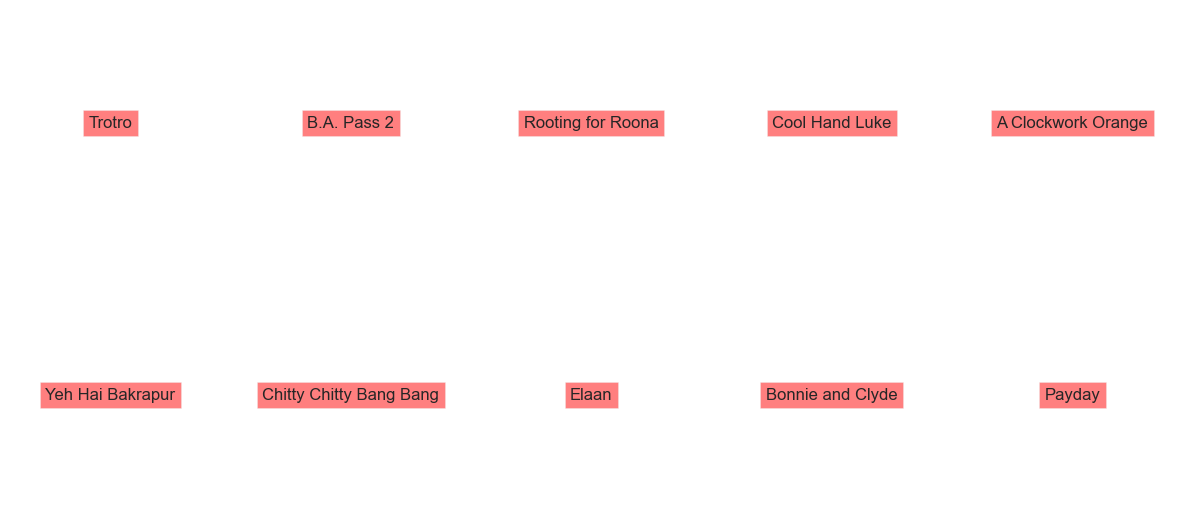

Menu de Recomendações
1. Inserir título do filme/série
2. Obter recomendação aleatória
3. Sair


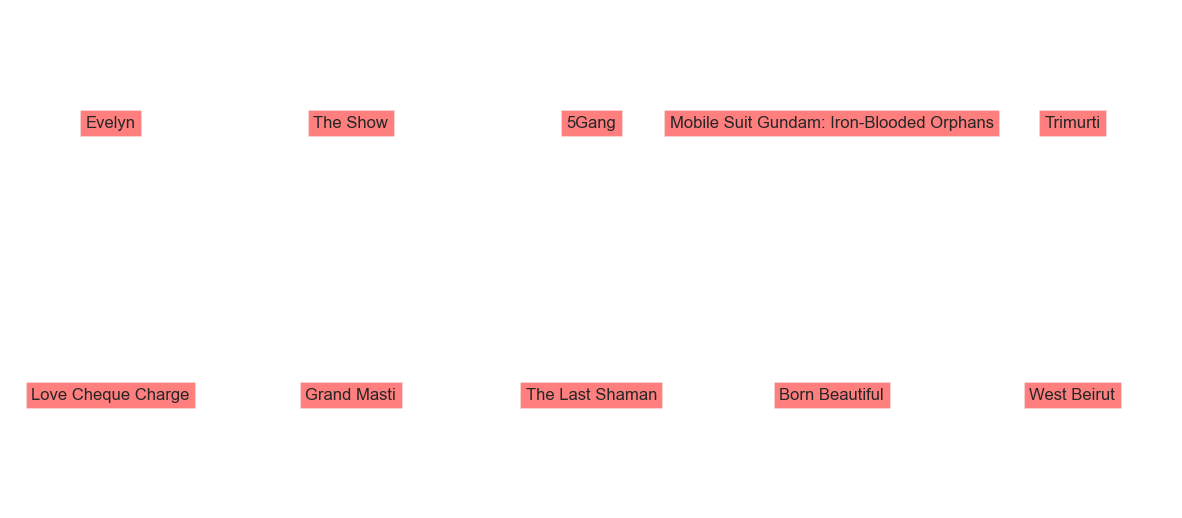

Menu de Recomendações
1. Inserir título do filme/série
2. Obter recomendação aleatória
3. Sair
Saindo...


In [15]:
# Função para visualizar as recomendações
def visualizar_recomendacoes(titulos):
    plt.figure(figsize=(15, 10))
    columns = 5
    for i, titulo in enumerate(titulos):
        ax = plt.subplot(len(titulos) // columns + 1, columns, i + 1)
        plt.text(0.5, 0.5, titulo, horizontalalignment='center', verticalalignment='center', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
        plt.axis('off')
    plt.show()

# Função para exibir o menu e capturar a entrada do usuário
def menu():
    while True:
        print("Menu de Recomendações")
        print("1. Inserir título do filme/série")
        print("2. Obter recomendação aleatória")
        print("3. Sair")
        choice = input("Escolha uma opção (1, 2, 3): ")

        if choice == '1':
            titulo = input("Digite o título do filme/série: ")
            recomendacoes = recomendador(titulo)
            if isinstance(recomendacoes, list):
                visualizar_recomendacoes(recomendacoes)
            else:
                print(recomendacoes)
        elif choice == '2':
            titulo = random.choice(df_netflix['title'].tolist())
            print(f"Recomendações para: {titulo}")
            recomendacoes = recomendador(titulo)
            visualizar_recomendacoes(recomendacoes)
        elif choice == '3':
            print("Saindo...")
            break
        else:
            print("Opção inválida. Tente novamente.\n")

# Chamando o menu interativo
menu()
